In [1]:
!pip install missingno

You should consider upgrading via the 'c:\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import re


import random
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import preprocessing
from pathlib import Path
import scipy.io
import py_pcha
import seaborn as sns
import missingno as msno

sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

In [3]:
l=list(string.ascii_uppercase)
b=np.array(l+[x+y for x in l for y in l])
b = b[:123]

In [4]:
data = pd.read_csv('MI.data', usecols = list(range(1,124)), names=b,header=None)

In [5]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,DJ,DK,DL,DM,DN,DO,DP,DQ,DR,DS
0,77,1,2,1,1,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0
1,55,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,52,1,0,0,0,2,?,2,0,2,...,0,0,0,0,0,0,0,0,0,0
3,68,0,0,0,0,2,?,2,0,3,...,0,0,0,0,0,0,1,0,0,0
4,60,1,0,0,0,2,?,3,0,7,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Columns: 123 entries, A to DS
dtypes: int64(13), object(110)
memory usage: 1.6+ MB


In [7]:
data = data.replace('?',np.nan)

In [8]:
for column in data.columns:
    data[column] = data[column].astype(float)

In [9]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,DJ,DK,DL,DM,DN,DO,DP,DQ,DR,DS
0,77.0,1.0,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.0,1.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,60.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# for column in data.columns:
#     plt.hist(data[column])
#     plt.show()

In [11]:
abbs = []
descriptions = []
types = []
counter = 1
with open('attributes.txt', 'r', encoding='utf8') as f:
    for line in f:
        split_line = line.split('.')
        num = split_line[0]
        try:
            num = int(num)
            if num == counter:
                counter += 1
                
                # Add description of attribute to list
                descriptions += [split_line[1]]
                
                # Add abbreviations of attributes to list
                abb_candidates = re.findall('\(.*?\)',line)
                if len(abb_candidates) == 1:
                    abbs += [abb_candidates[0][1:-1]]
                else:
                    abbs += [re.sub('[()]', '', a) for a in abb_candidates if '_' in a]
                    
                # Add data type to list
                if 'Nominal' in line:
                    types += ['Nominal']
                elif 'Ordinal' in line:
                    types += ['Ordinal']
                elif 'Real' in line:
                    types += ['Real']
                else:
                    print(line)
        except:
            pass
        
f.close()

abbs = np.array(abbs)
descriptions = np.array(descriptions)
types = np.array(types)

1. Record ID (ID): Unique identifier. Cannot be related to participant. It can be used for reference only.



In [12]:
data.columns = abbs[1:]

In [13]:
data['DECEASED'] = data.LET_IS.apply(lambda x: x if x == 0 else 1)
abbs = np.append(abbs, 'DECEASED')
descriptions = np.append(descriptions, 'Whether or not patient is deceased')
types = np.append(types,'Nominal')

In [14]:
data.head()

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,IBS_NASL,GB,SIM_GIPERT,DLIT_AG,...,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS,DECEASED
0,77.0,1.0,2.0,1.0,1.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,52.0,1.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,68.0,0.0,0.0,0.0,0.0,2.0,NaN,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,60.0,1.0,0.0,0.0,0.0,2.0,NaN,3.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
attributes = dict(zip(abbs, descriptions))

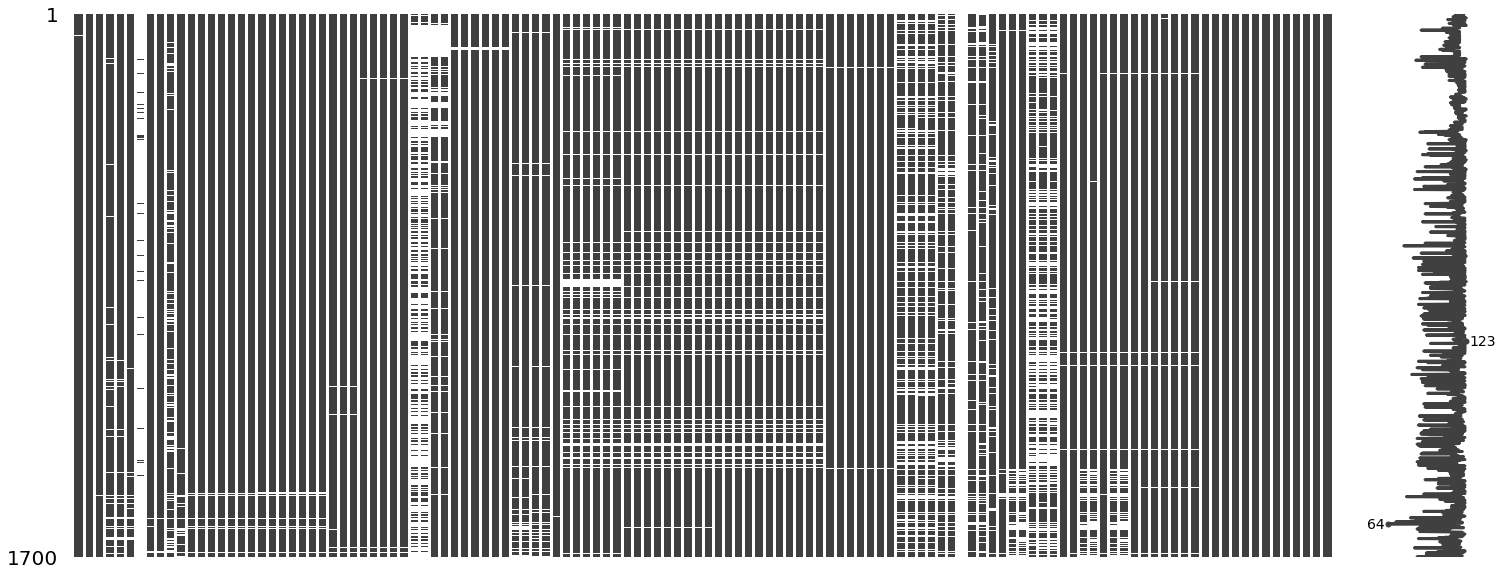

In [16]:
msno.matrix(data)
plt.show()

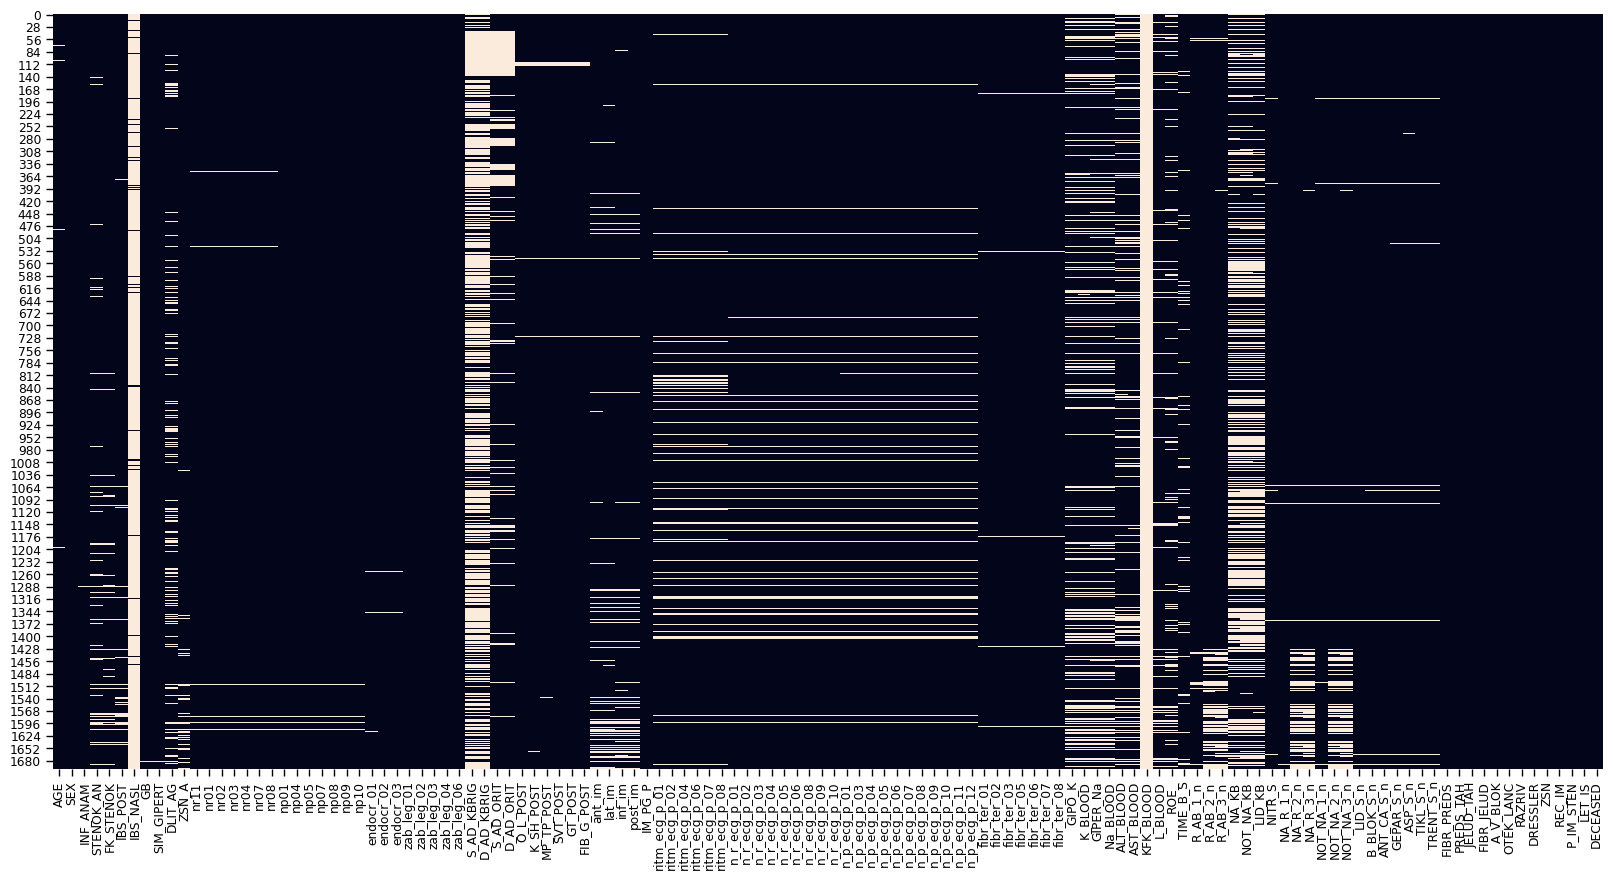

In [50]:
sns.set_context('paper')
plt.figure(figsize = (20,10), dpi = 100)
sns.heatmap(data.isnull(), cbar=False);
sns.set_context('poster')

In [32]:
X_total = data[data.columns[:111]]
X_total = X_total.drop(abbs[np.array([93, 94, 95, 100, 101, 102, 103, 104, 105]) - 2], axis=1)

X_total.shape

(1700, 102)

In [39]:
# Drop columns with percentage of nans higher than threshold
threshold = 0.1 # variable from 0 - 1

drop_c = []
for c in X_total.columns:
    if (X_total[c].isna().sum()) / len(X_total) >= threshold:
        drop_c += [c]
    
dropped_at_threshold = X_total.drop(drop_c, axis=1)

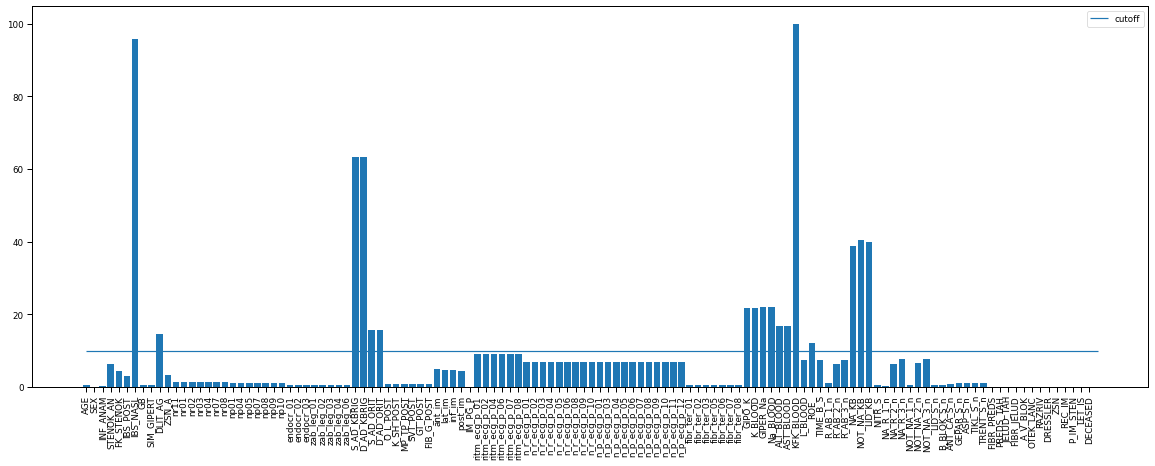

In [34]:
nans = []
for column in data.columns:
    a = (sum(data[column].isnull()) / 1700) * 100
    nans += [a]
plt.figure(figsize = (20,7))
plt.bar(list(range(124)),nans)
plt.xticks(list(range(124)), data.columns.values, rotation = 90)
plt.hlines(threshold*100, 0, 124, label = 'cutoff')
plt.legend()
plt.show()

In [42]:
dropped_at_threshold.shape

(1700, 85)

In [43]:
# fill remaining nans with mode
dropped_filled_mode = dropped_at_threshold.copy()
for c in dropped_data.columns:
    dropped_filled_mode[c] = dropped_filled_mode[c].fillna(dropped_filled_mode[c].mode()[0])

In [47]:
X_mode = np.array(dropped_filled_mode)

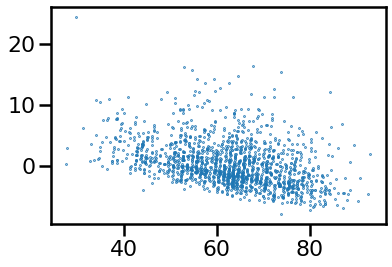

In [51]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3)
# prepare transform on dataset
svd.fit(X_mode)
transformed_X = svd.transform(X_mode)

plt.scatter(transformed_X[:,0], transformed_X[:,1], s=0.5)

In [52]:
transformed_X.shape

(1700, 3)

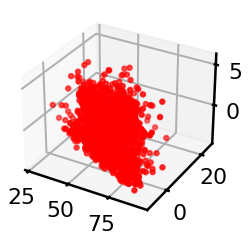

In [53]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed_X[:,0], transformed_X[:,1],transformed_X[:,2], c='r', marker='o')

plt.show()

# Tree based methods

## Decision tree classifier



In [180]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

In [166]:
X = np.array(dropped_filled_mode)
y = data['DECEASED'].ravel()

In [167]:
dtree = DecisionTreeClassifier(random_state=0) # Make classifier

ccp_alphas = np.linspace(0, 1, 50)
param_grid = {
    'ccp_alpha': ccp_alphas,
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': range(1,11)    
}
# CV to find best parameters
cv_grid = GridSearchCV(estimator = dtree, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# Fit the grid search model
cv_grid.fit(X, y)
print(cv_grid.best_estimator_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
DecisionTreeClassifier(ccp_alpha=0.02040816326530612, random_state=0)


In [172]:
def true_percentage(y_true, y_pred):
    y_pred_trues = y_pred[y_true == 1]
    percentage = y_pred_trues.sum() / len(y_pred_trues)
    if np.isnan(percentage):
        return 0 
    else: 
        return percentage

In [173]:
K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
decisiontree = cv_grid.best_estimator_
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    decisiontree.fit(X_train, y_train)
    
    y_pred = decisiontree.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

## Bagging Classifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [175]:
bagging = BaggingClassifier(DecisionTreeClassifier(), bootstrap=True, oob_score = True)

param_grid = {
    'n_estimators': range(1,150),    
}

bagging_grid = GridSearchCV(estimator = bagging, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# Fit the grid search model
bagging_grid.fit(X, y)
print(f'best estimator: {bagging_grid.best_estimator_}')

Fitting 5 folds for each of 149 candidates, totalling 745 fits
best estimator: BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=18,
                  oob_score=True)


In [179]:
K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
bagging_classifier = bagging_grid.best_estimator_
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    bagging_classifier.fit(X_train, y_train)
    
    y_pred = bagging_classifier.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

Overall accuracy: 0.868
Of cases where the response variable of y_true is true, the accuracy is: 0.322


## Random forest classifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [184]:
rfc = RandomForestClassifier(bootstrap=True, oob_score=True, criterion = 'gini',random_state=0)

# number of trees
n_estimators = range(5,101)
max_depth = range(1,11)
max_features = range(10,250,20)

# Try to add more of the parameters from the model and then add them to this dict to see how it affects the model.
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
}

rf_grid = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

# Fit the grid search model
rf_grid.fit(X, y)

print(rf_grid.best_estimator_)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
RandomForestClassifier(max_depth=8, n_estimators=10, oob_score=True,
                       random_state=0)


In [185]:
K = 20 # number of folds in cross validation
kf = KFold(n_splits = K, shuffle = True, random_state = 42)
rfc = rf_grid.best_estimator_
training_error = []
test_error = []
training_error_of_trues = []
test_error_of_trues  = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Split into train and testing data
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    rfc.fit(X_train, y_train)
    
    y_pred = rfc.predict(X_test)
    
    test_error += [accuracy_score(y_test, y_pred)]
    test_error_of_trues += [true_percentage(y_test, y_pred)]

test_error = np.array(test_error)
test_error_of_trues = np.array(test_error_of_trues)

print(f"Overall accuracy: {test_error.mean():0.3f}")
print(f"Of cases where the response variable of y_true is true, the accuracy is: {test_error_of_trues.mean():0.3f}")

Overall accuracy: 0.865
Of cases where the response variable of y_true is true, the accuracy is: 0.216


## AdaBoost

An AdaBoost [1] classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [191]:
# Try to experiment with max_samples, max_features, number of modles, and other models
n_estimators = range(5,101)
max_depth = range(3,11)
learning_rate = np.linspace(1,5,5)
#We do an outer loop over max_depth here ourselves because we cannot include in the CV paramgrid.
#Notice this is not a "proper" way to select the best max_depth but for the purpose of vizuallizing behaviour it should do
test_acc = np.zeros((len(n_estimators), len(max_depth)))
for j, i in enumerate(max_depth):
    # Create and fit an AdaBoosted decision tree
    boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                             learning_rate=1.0)

    param_grid = {
        'n_estimators': n_estimators,
        'learning_rate' : learning_rate
    }
    boost_grid = GridSearchCV(estimator = boost, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

    # Fit the grid search model
    boost_grid.fit(X, y)

    test_acc[:,j] = boost_grid.cv_results_['mean_test_score']
    

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

ax.plot(n_estimators, test_acc)
ax.set_xlabel('Maximum tree depth')
ax.set_ylabel('Mean test accuracy')
ax.legend(['MaxDepth=1','MaxDepth=2','MaxDepth=3','MaxDepth=4','MaxDepth=5','MaxDepth=6','MaxDepth=7','MaxDepth=8','MaxDepth=9','MaxDepth=10'])